# Pedestrian Data Plotting
## Imports

In [1]:
%matplotlib notebook
import torch
from lstm_motion_model import models, datasets, plots, pedestrian_sequence
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt, colors
import numpy as np
figsize=[8,12]

## Load data

In [2]:
input_files = [
    '/home/alex/data/public/ewap_dataset/seq_eth/obsmat_5hz.dense',
    '/home/alex/data/public/ewap_dataset/seq_hotel/obsmat_5hz.dense',
    '/home/alex/data/simulated/sidewalk_chaos/5hz_crop/2019-07-05-15-22-03_0.dense'
]
all_datasets = [datasets.CrowdSequenceDataset(f) for f in input_files]
hz = 5.0
for dataset in all_datasets:
    print(dataset[0].shape)
print (30*600)

torch.Size([3867, 360, 2])
torch.Size([3612, 389, 2])
torch.Size([598, 226, 2])
18000


<IPython.core.display.Javascript object>


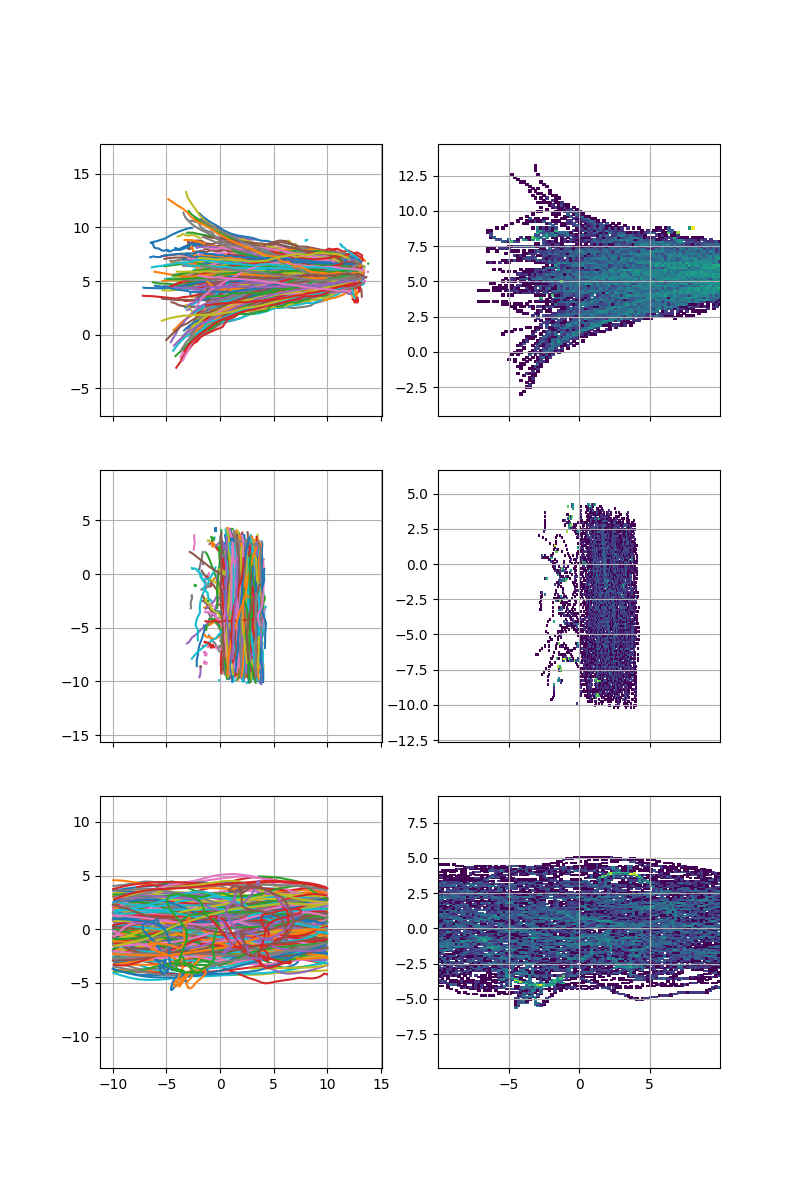

In [3]:
fig, axes = plt.subplots(
    len(all_datasets), 2,
    sharex='col',# sharey='col',
    subplot_kw={'adjustable':'datalim', 'aspect':'equal'},
    figsize=figsize)
for idx, dataset in enumerate(all_datasets):
    sequence = dataset[0]
    positions = sequence.numpy()
    X = positions
    ax = axes[idx, 0]
    ax.plot(X[:,:,0], X[:,:,1])
    ax.grid(True, 'both', 'both')
#     ax.set_aspect('equal', adjustable='box', share=True)
    plt.show()
    
    X = X.reshape(-1,2)
    nans = np.isnan(X).any(-1)
    X = X[~nans, :]
    ax = axes[idx, 1]
    ax.hist2d(X[:,0], X[:,1], bins=100, norm=colors.LogNorm())
    ax.grid(True, 'both', 'both')
#     ax.set_aspect('equal', adjustable='box', share=True)
    
    
    plt.show()

## Plot Velocity and Acceleration in Global Frame

<IPython.core.display.Javascript object>


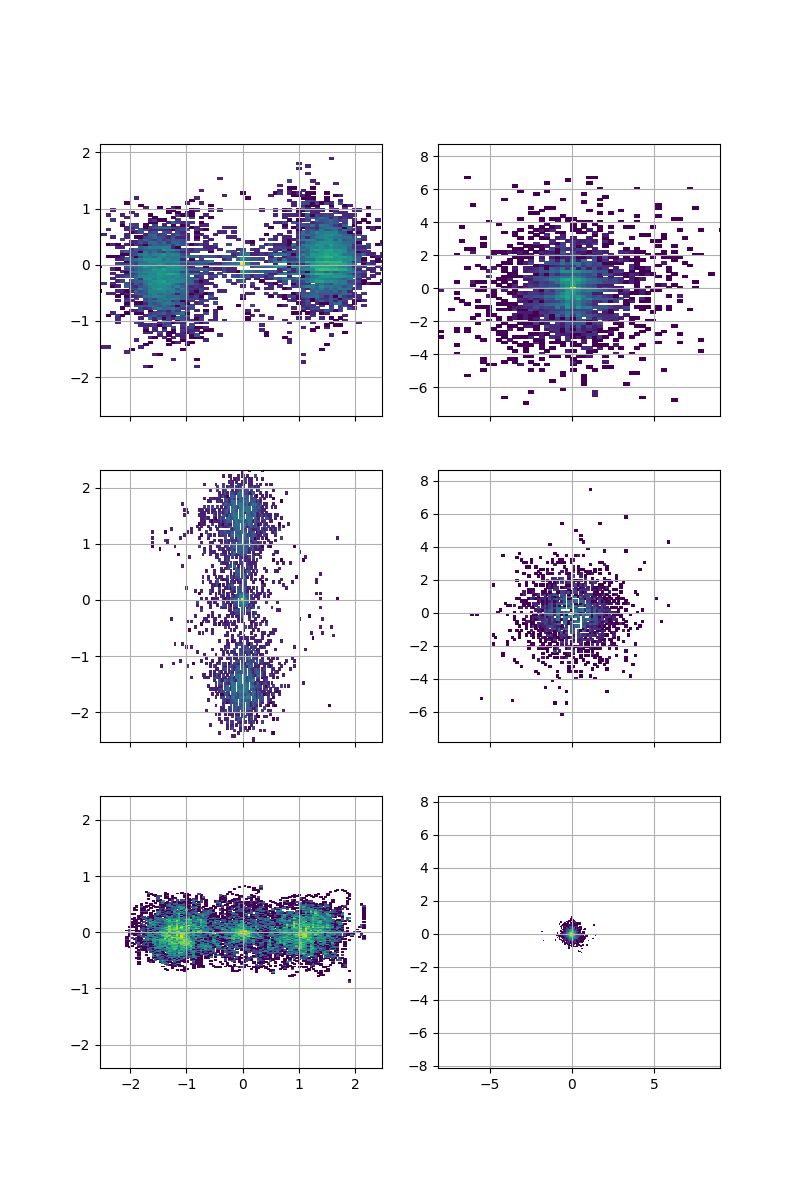

In [4]:
fig, axes = plt.subplots(
    len(all_datasets), 2,
    sharex='col',# sharey='col',
    subplot_kw={'adjustable':'datalim', 'aspect':'equal'},
    figsize=figsize)
for idx, dataset in enumerate(all_datasets):
    sequence = dataset[0]
    positions = sequence.numpy()
    velocities = np.diff(positions, axis=0) * hz
    accelerations = np.diff(velocities, axis=0) * hz
    plot_data = [velocities, accelerations]
    for d_idx, data in enumerate(plot_data):
        X = data.reshape(-1, 2)
        nans = np.isnan(X).any(-1)
        X = X[~nans, :]
        ax = axes[idx, d_idx]
        ax.hist2d(X[:,0], X[:,1], bins=100, norm=colors.LogNorm())
        ax.grid(True, 'both', 'both')
    plt.show()

## Plot Velocity and Acceleration in Heading Frame

<IPython.core.display.Javascript object>


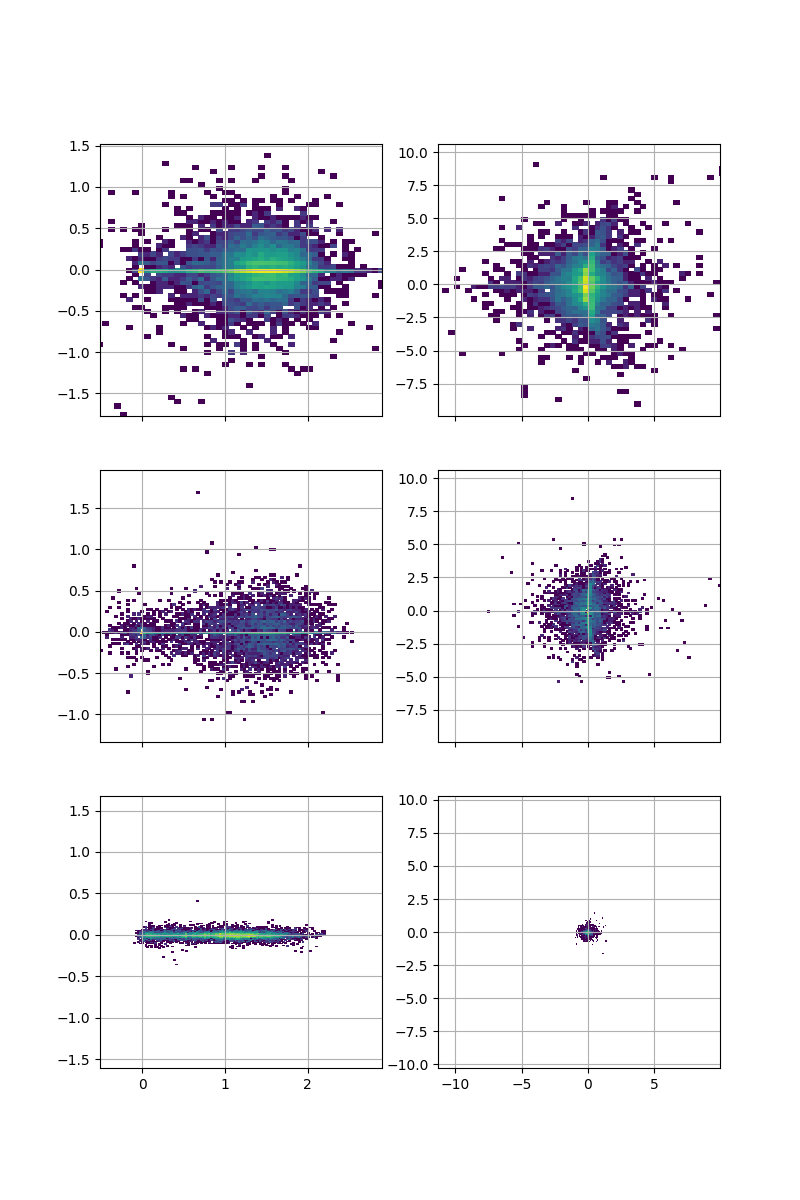

(1391400, 2, 2)
(1391400, 2, 1)
(1404290, 2, 2)
(1404290, 2, 1)
(134696, 2, 2)
(134696, 2, 1)


In [5]:
fig, axes = plt.subplots(
    len(all_datasets), 2,
    sharex='col',# sharey='col',
    subplot_kw={'adjustable':'datalim', 'aspect':'equal'},
    figsize=figsize)
for idx, dataset in enumerate(all_datasets):
    sequence = dataset[0]
    positions = sequence.numpy()
    velocities = np.diff(positions, axis=0) * hz
    angles = np.arctan2(velocities[:,:,1],velocities[:,:,0])
    # Align velocities and angles
    velocities = velocities[1:,:,:]
    angles = angles[:-1,:]
    seq_len, num_ppl, dims = velocities.shape
    v = velocities.reshape(-1, 2, 1)
    theta = angles.reshape(-1)
    c = np.cos(-theta)
    s = np.sin(-theta)
    R = np.stack([np.stack([c, -s], -1), np.stack([s, c], -1)], -2)
    # c, -s     v1     v1'
    # s,  c  X  v2  =  v2'
    print(R.shape)
    print(v.shape)
    rel_v = np.matmul(R, v)
    rel_a = np.diff(rel_v.reshape(seq_len, num_ppl, 2), axis=0) * hz

    ax = axes[idx, 0]
    X = rel_v.reshape(-1, 2)
    nans = np.isnan(X).any(-1)
    X = X[~nans, :]
    ax.hist2d(X[:,0], X[:,1], bins=100, norm=colors.LogNorm())
    ax.grid(True, 'both', 'both')
#     ax.set_aspect('equal')

    ax = axes[idx, 1]
    X = rel_a.reshape(-1, 2)
    nans = np.isnan(X).any(-1)
    X = X[~nans, :]
    ax.hist2d(X[:,0], X[:,1], bins=100, norm=colors.LogNorm())
    ax.grid(True, 'both', 'both')
#     ax.set_aspect('equal')
    
    plt.show()

<IPython.core.display.Javascript object>


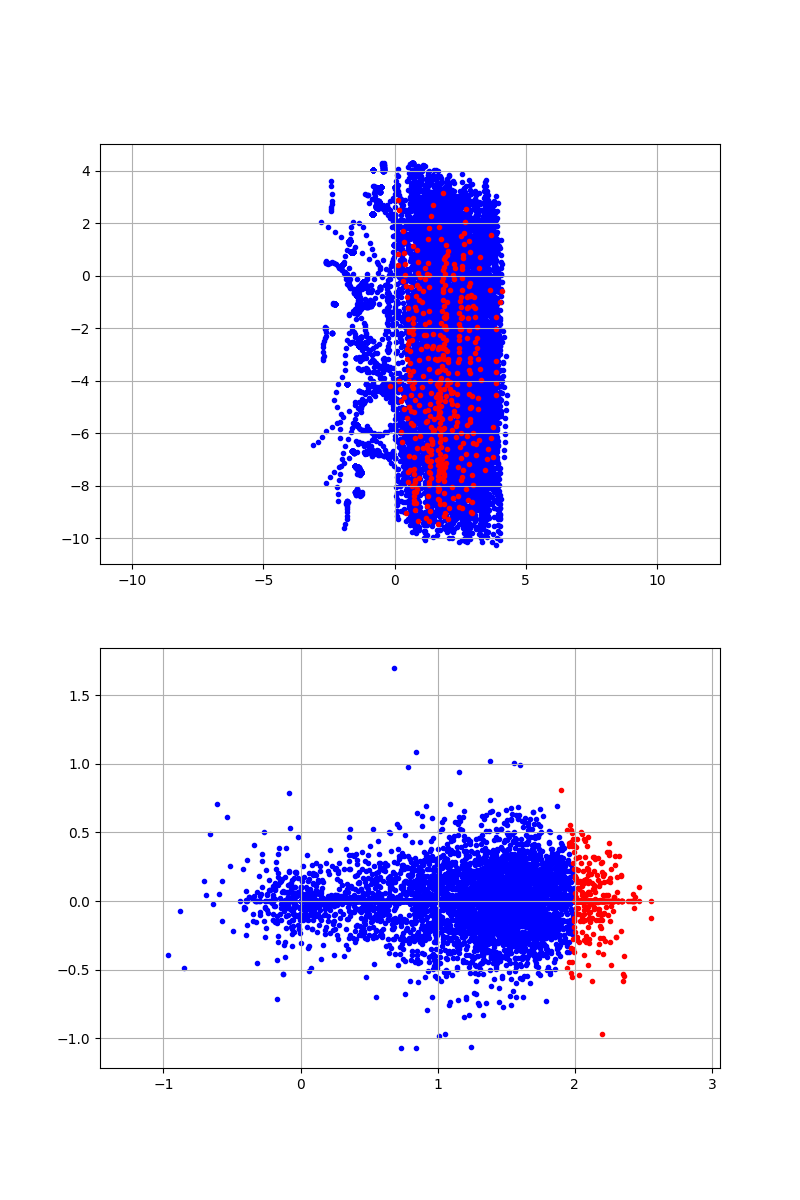

(3610, 389, 2)
(3610, 389, 2)
(3610, 389)


/home/alex/python-env/pytorch-env/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


In [6]:
fig, axes = plt.subplots(
    2, 1,
    sharex=False,# sharey='col',
    subplot_kw={'adjustable':'datalim', 'aspect':'equal'},
    figsize=figsize)
dataset = all_datasets[1]
sequence = dataset[0]
positions = sequence.numpy()
velocities = np.diff(positions, axis=0) * hz
angles = np.arctan2(velocities[:,:,1],velocities[:,:,0])
# Align velocities and angles
positions = positions[2:,:,:]
velocities = velocities[1:,:,:]
angles = angles[:-1,:]
seq_len, num_ppl, dims = velocities.shape
print(positions.shape)
print(velocities.shape)
print(angles.shape)

v = velocities.reshape(-1, 2, 1)
theta = angles.reshape(-1)
c = np.cos(-theta)
s = np.sin(-theta)
R = np.stack([np.stack([c, -s], -1), np.stack([s, c], -1)], -2)
# c, -s     v1     v1'
# s,  c  X  v2  =  v2'
rel_v = np.matmul(R, v)
rel_v = rel_v.reshape(seq_len, num_ppl, 2)

data_copy = rel_v.copy()
finite = np.all(np.isfinite(data_copy[:,:,:]), axis=-1)
data_copy[~finite,:] = 0.0
selected = np.abs(data_copy[:,:,1]) > 0.4

selected = np.linalg.norm(rel_v[:,:,:], axis=-1) > 2.0
# selected = selected & finite

ax = axes[0]
ax.scatter(positions[~selected,0], positions[~selected,1], c='blue', marker='.')
ax.scatter(positions[selected,0], positions[selected,1], c='red', marker='.')
ax.grid(True, 'both', 'both')

ax = axes[1]
ax.scatter(rel_v[~selected,0], rel_v[~selected,1], c='blue', marker='.')
ax.scatter(rel_v[selected,0], rel_v[selected,1], c='red', marker='.')
ax.grid(True, 'both', 'both')
# v = velocities.reshape(-1, 2, 1)
# theta = angles.reshape(-1)
# c = np.cos(-theta)
# s = np.sin(-theta)
# R = np.stack([np.stack([c, -s], -1), np.stack([s, c], -1)], -2)
# # c, -s     v1     v1'
# # s,  c  X  v2  =  v2'
# print(R.shape)
# print(v.shape)
# rel_v = np.matmul(R, v)
# rel_a = np.diff(rel_v.reshape(seq_len, num_ppl, 2), axis=0) * hz

# ax = axes[idx, 0]
# X = rel_v.reshape(-1, 2)
# nans = np.isnan(X).any(-1)
# X = X[~nans, :]
# ax.hist2d(X[:,0], X[:,1], bins=100, norm=colors.LogNorm())
# ax.grid(True, 'both', 'both')
# ax.set_aspect('equal')


plt.show()

Skipped 176 people due to invalid index


<IPython.core.display.Javascript object>


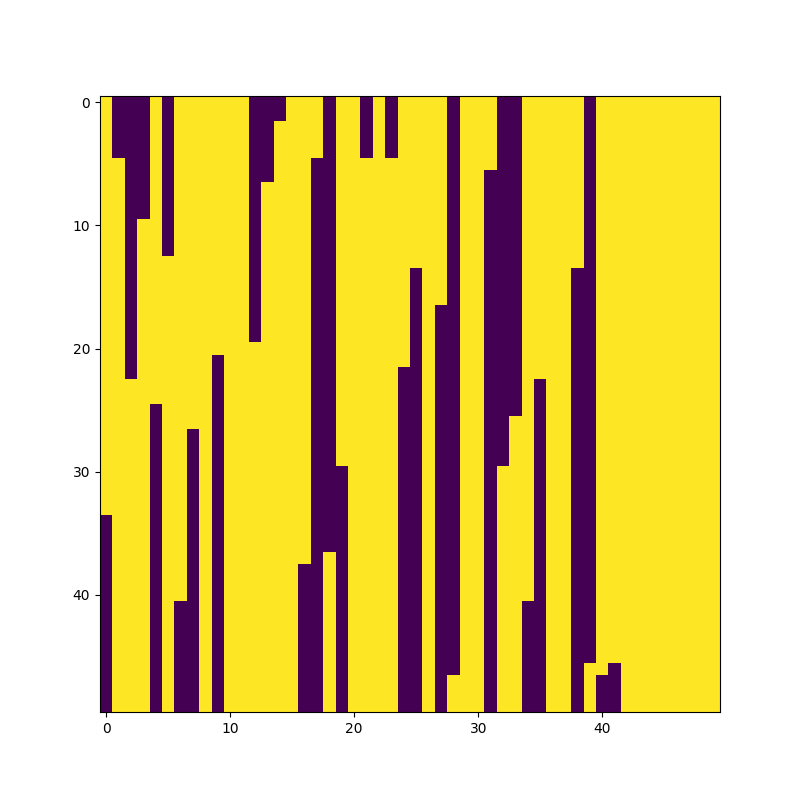

In [7]:
dataset = datasets.CrowdSequenceDataset(input_files[2], sequence_length=50)
sequence = dataset[0]
plt.figure(figsize=(8,8))
plt.imshow(np.all(np.isfinite(sequence.numpy()), axis=-1), aspect='auto')

<IPython.core.display.Javascript object>


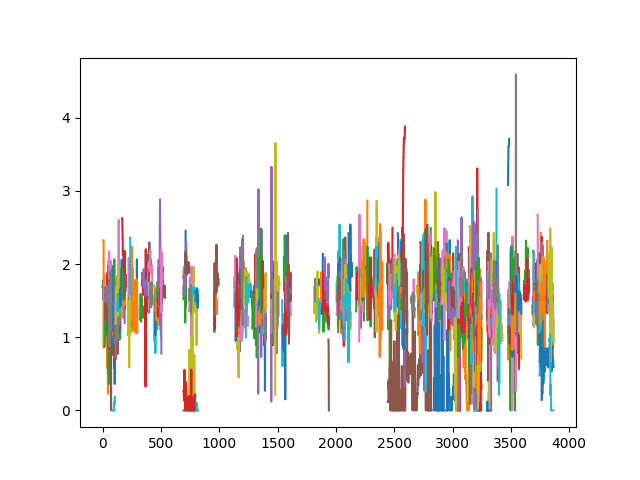

(3866, 360, 2)
(3866, 360)


<IPython.core.display.Javascript object>


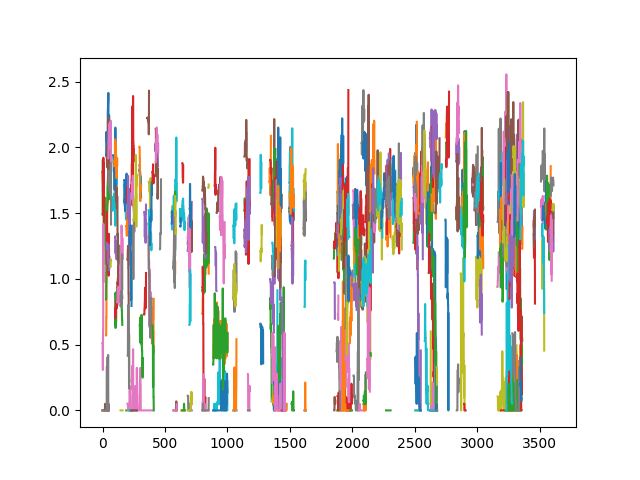

(3611, 389, 2)
(3611, 389)


<IPython.core.display.Javascript object>


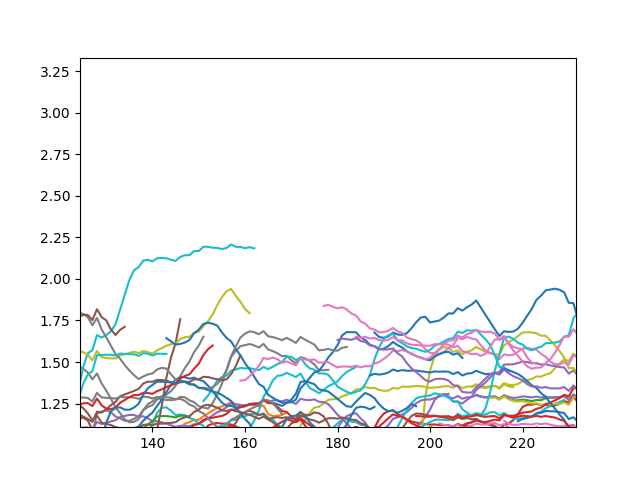

(597, 226, 2)
(597, 226)


In [8]:

for idx, dataset in enumerate(all_datasets):
    plt.figure()
    sequence = dataset[0]
    positions = sequence.numpy()
    velocities = np.diff(positions, axis=0) * hz

    magnitude = np.linalg.norm(velocities, axis=-1)
    plt.plot(magnitude)
    print(velocities.shape)
    print(magnitude.shape)